<a href="https://colab.research.google.com/github/babymlin/Style_transfer_gan/blob/main/ImPiccso_pytorch_1100616.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.8.1 torchvision==0.9.0 torchaudio==0.8.0

In [ ]:
import torch
torch.__version__

'1.8.1+cu111'

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 大藝術家 (pytorch)

In [ ]:
import os
import builtins
os.environ['TRIDENT_BACKEND'] = 'pytorch'
!pip install tridentx==0.7.3.5
import trident as T
from trident import *
from trident.data.data_provider import DataProvider
from trident.models import vgg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
display.Image('/content/drive/MyDrive/Colab Notebooks/style_transform_gan/gan_image/inp2_scalar.png',width=300)

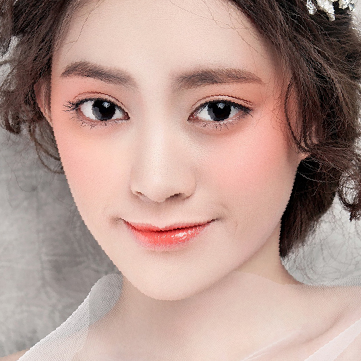

In [ ]:
display.Image('/content/drive/MyDrive/Colab Notebooks/style_transform_gan/gan_image/vFG112.png',width=300)

In [ ]:

content_img_path='/content/drive/MyDrive/Colab Notebooks/style_transform_gan/gan_image/inp2_scalar.png'
style_img_path='/content/drive/MyDrive/Colab Notebooks/style_transform_gan/gan_image/vFG112.png'

content_array=image2array(content_img_path) #讀取一下取得尺寸資訊
H,W,C=content_array.shape


#ImageDataset可以直接輸入圖檔路徑的清單，即可自動轉換成圖檔向量，且依照backend擺放通道位置
content_dataset=ImageDataset(images=[content_img_path]*1000,symbol='content')
style_dataset=ImageDataset(images=[style_img_path]*1000,symbol='style')



iter_data=Iterator(data=ZipDataset(content_dataset,style_dataset),batch_size=1)
         
data_provider=DataProvider(traindata=iter_data)
data_provider.image_transform_funcs=[
                     resize((H,W),keep_aspect=False),
                     normalize(0,255),
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
print(data_provider.signature)


content_img,style_img=data_provider.next()
print(content_img.shape)
print(style_img.shape)

data_provider( ) -> content: Tensor[(None, 3, 256, 256)] (ObjectType.rgb), style: Tensor[(None, 3, 256, 256)] (ObjectType.rgb) 
(1, 3, 256, 256)
(1, 3, 256, 256)


In [ ]:
process_img=to_tensor(content_img.copy(),requires_grad=True)

inputs=OrderedDict()
inputs['content']=content_img
inputs['style']=style_img

style_transfer=Model(inputs=inputs,output=process_img)
print(style_transfer.signature)

None( content: Tensor[(None, 3, 256, 256)] , style: Tensor[(None, 3, 256, 256)] ) -> output: Tensor[(None, 3, 256, 256)] (ObjectType.rgb) 


In [ ]:
vgg16=vgg.VGG16(include_top=False,pretrained=True,freeze_features=True)
vgg16.summary()

model file is already existing, donnot need download again.
138357544 parameters have set untrainable
4097000 parameters have set trainable
16781312 parameters have set trainable
102764544 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
          Layer (type)            Output Shape               Weight                          Bias      Param #   FLOPS #                  
block1_conv1  [Conv2d]            [None, 64, 224, 224]       'weight', [64, 3, 3, 3]         'bias', [64]  1,792  179,730,432  
block1_relu1  [Relu]              [None, 64, 224, 224]                                                 0  0  
block1_conv2  [Conv2d]            [None, 64, 224, 224]       'weight', [64, 64, 3, 3]        'bias', [64]  36,928  3,705,698,304  
block1_relu2  [Relu]              [None, 64, 224, 224]                                                 0  0  
block1_pool  [MaxPool2d]          

ImageClassificationModel()

In [ ]:
#content_features_layers = ['block2_conv2', 'block4_conv2']　＃比較寫實
content_features_layers = [ 'block4_conv2','block5_conv2'] #比較抽象

style_feature_layers = OrderedDict()
style_feature_layers['block1_conv1'] = 0.75
style_feature_layers['block2_conv1'] = 1
style_feature_layers['block3_conv1'] = 2
style_feature_layers['block3_conv3'] = 2
style_feature_layers['block4_conv1'] = 2
style_feature_layers['block4_conv3'] = 2
style_feature_layers['block5_conv1'] = 2
style_feature_layers['block5_conv3'] = 2

In [ ]:

for name, Layer in vgg16.model.named_modules():
    if name in content_features_layers or name in style_feature_layers:
        Layer.keep_output = True

In [ ]:

def content_loss(output, content):
    content.detach()
    content_features = OrderedDict()
    output_features = OrderedDict()
    
    # 將內容圖送入vgg16
    _ = vgg16.model(content)

    # 把剛才設定了keep_output的結果都保存起
    for name, Layer in vgg16.model.named_modules():
        if name in content_features_layers:
            content_features[name] = Layer.output.detach()

    # 將output送入vgg16
    _ = vgg16.model(output)

    # 把剛才設定了keep_output的結果都保存起來
    for name, Layer in vgg16.model.named_modules():
        if name in content_features_layers:
            output_features[name] = Layer.output

    loss = 0
    # 將內容相關神經層取出，計算均方差
    total = (1 - 0.8 ** (len(style_feature_layers) + 1)) / (1 - 0.8)
    for i in range(len(content_features_layers)):
        name=content_features_layers[i]

        #content_loss[name]=\
        weight = 0.8 ** (i + 1) / total
        loss=loss+weight*(((output_features[name] - content_features[name]) ** 2).sum())/(3*H*W)
    return loss


def style_loss(output, style):
    style.detach()
    style_features = OrderedDict()
    output_features = OrderedDict()

    # 將風格圖送入vgg16
    _ = vgg16.model(style)
    # 把剛才設定了keep_output的結果都保存起來
    for name, Layer in vgg16.model.named_modules():
        if name in style_feature_layers:
            style_features[name] = Layer.output.detach()

    # 將output送入vgg16
    _ = vgg16.model(output)
    # 把剛才設定了keep_output的結果都保存起來
    for name, Layer in vgg16.model.named_modules():
        if name in style_feature_layers:
            output_features[name] = Layer.output

    loss = 0
    # 將內容相關神經層取出，計算均方差(除以該神經層的圖片尺寸與通道數)，並乘上對應權重
    #這次加入了各層的加權遞增(越後面越抽象越重要)
    
    total = (1 - 0.8 ** (len(style_feature_layers) +1)) / (1 - 0.8)
    for i in range(len(style_feature_layers)):
        name=style_feature_layers.key_list[i]
        b, c, h, w = style_features[name].shape
        weight = style_feature_layers[name]*(0.8**(len(style_feature_layers)-i)/total)
        
        g1=gram_matrix(output_features[name]-output_features[name].mean())
        
        g2=gram_matrix(style_features[name]-style_features[name].mean())
        
        gg=((g1 - g2.detach()) ** 2).sum()/(c*h*w)
        
        loss=loss+weight *gg

    return loss



In [ ]:
#為了觀察圖片的變化程度，因此自訂一個函數，來計算輸出圖片與原始內容圖的差異程度

def diff(output,content):
    return (output-content).abs().mean()/content.abs().mean()

In [ ]:
def print_loss(training_context):
    #從training_context中取出個別損失函數數值
    print('content_loss',training_context['losses']['content_loss'][-1][-1],
    'style_loss',training_context['losses']['style_loss'][-1][-1])

style_transfer.with_optimizer(optimizer='LBFGS')\
    .with_loss(content_loss,5)\
    .with_loss(style_loss, 120)\
    .with_metric(diff)\
    .trigger_when('on_batch_end',10,action=print_loss)\
    .with_regularizer('total_variation_norm_reg',reg_weight=1)\
    .with_callbacks(TileImageCallback(frequency=50, unit='batch', row=1, reverse_image_transform=data_provider.reverse_image_transform, include_input=False, include_output=True,
                      include_mask=False, include_target=False, imshow=True))

#將data_provider送出數據的第0個做為輸出
#使用LBFGS作為優化器
#設定內容損失，權重為1~250之間
#設定風格損失，權重為1~250之間

#設定diff做為評估指標
#設定total_variation_loss，權重為0.1
#設定TileImageCallback，每隔50個批次畫一次圖，只需要納入輸出，一次顯示一列(也就是每個圖都顯示一張)

content_loss( output: Tensor[None] , content: Tensor[None] ) -> output: Tensor[(None,)]  
style_loss( output: Tensor[None] , style: Tensor[None] ) -> output: Tensor[(None,)]  
diff( output: Tensor[None] , content: Tensor[None] ) -> output: Tensor[(None,)]  


Model(
  (_losses): <function content_loss at 0x7f6266510050>
  (_losses): <function style_loss at 0x7f62665105f0>
  (_metrics): <function diff at 0x7f62665944d0>
  (loss_weights): 5.0
  (loss_weights): 120.0
  (_regs): <function total_variation_norm_reg at 0x7f62671a9200>
)

In [ ]:

plan = TrainingPlan().add_training_item(style_transfer, name='style_transfer')\
    .with_data_loader(data_provider)\
    .repeat_epochs(10)\
    .with_batch_size(1)\
    .print_progress_scheduling(10,unit='batch')

#將前面設定好的style_transfer作為training item
#設定data_provider
#epoch設定為5 (可以視產出結果進行調整)
#批次大小為1
#每隔5個批次列印一次進度

In [ ]:
plan.start_now()